In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import torch
import copy

In [2]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', **{'family': 'serif', 'size' : 12})
rc('figure', **{'figsize' : (5, 3)})

In [3]:
sys.path.insert(1, '../..')

In [4]:
from solvers.PoissonSolver import PoissonSolver
from config_step_4 import PARAMS_SOLVER

In [5]:
np.random.seed(seed=123)

In [6]:
PARAMS_SOLVER

{'equation': 'Poisson', 'domain': [0.0, 1.0], 'D': None, 'nx': 101}

In [7]:
def logn_fct(grid, num_fct, sigma=0.1, centers=None):
    D_logs = []

    if centers is None:
         centers = np.random.uniform(0.2, 0.8, num_fct)
        
    for c in centers:
        D_log = np.exp(-(grid - c)**2 / (2 * sigma**2)) + 1e-1
        D_logs.append(D_log)
    
    return np.stack(D_logs)

In [8]:
def delta(y, x, dy = 1., dx = 0.) :
    """    
    y : int, float or ndarray of size 1
    x : ndarray
    
    return dy if x = y and dx otherwise
    """
    if torch.is_tensor(y):
        return torch.where(torch.isclose(torch.Tensor(x), y), dy, dx)
    if not isinstance(y, np.ndarray):
        y = np.array(y)
    return np.where(np.isclose(np.array(x), y), dy, dx)

In [9]:
x = np.linspace(0., 1., 101)
D = logn_fct(x, 1, centers=[0.5])[0]
F = delta(0.2, x)

PARAMS_SOLVER['source_term'] = lambda y, x: delta(y,x)
PARAMS_SOLVER['D'] = D
PARAMS_SOLVER['F'] = F

In [10]:
params_solver = copy.deepcopy(PARAMS_SOLVER)
solver = PoissonSolver(params=params_solver)

In [11]:
u = solver.solve

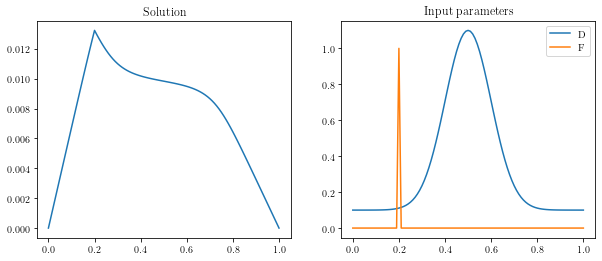

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(solver.x, u)
ax2.plot(solver.x, D, label='D')
ax2.plot(solver.x, F, label='F')

ax1.set_title('Solution')
ax2.set_title('Input parameters')
ax2.legend()
plt.show()

In [13]:
Y_list = solver.x[20:81].reshape(-1, 1)
VD = logn_fct(x, num_fct=61, centers=Y_list)
VF = delta(Y_list, solver.x)

In [14]:
# Vectorized solver
VU = solver.Vsolve(vect = 'DF', D=VD, F = VF)

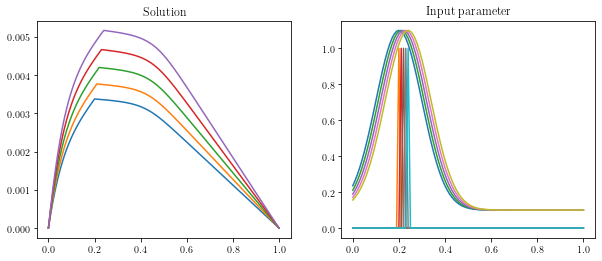

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
for sample in range(0, 5):
    ax1.plot(solver.x, VU[sample])
    ax2.plot(solver.x, VD[sample], label='D')
    ax2.plot(solver.x, VF[sample], label='F')
ax1.set_title('Solution')
ax2.set_title('Input parameter')
plt.show()

In [16]:
from methods.DataDrivenMethods import DDMethod

In [17]:
# chose methods that you want to use
# method_names = ['POD', 'MLP', 'DEEPONET', 'PINN', 'MLPINN', 'FNO'] 
method_names = ['POD', 'MLP', 'DEEPONET', 'FNO']

In [18]:
from config_step_4 import PARAMS_METHODS, HYPERPARAMS_METHODS

In [19]:
PARAMS_METHODS['MLP']

{'method_name': 'MLP',
 'layer_dims': [3, 21, 105, 119, 21, 69, 55, 1],
 'activations': ['relu', 'relu', 'relu', 'tanh', 'tanh', 'relu'],
 'device': device(type='cuda'),
 'seed': 123}

In [20]:
all_methods = {}
for method in method_names:
    params_method = copy.deepcopy(PARAMS_METHODS[method])
    params = {'solver': params_solver, 'method': params_method}
    all_methods[method] = DDMethod(params=params)

In [21]:
VDF = np.concatenate([np.expand_dims(VD, -1), np.expand_dims(VF, -1)], axis=-1)

In [22]:
df_train, df_val, u_train, u_val = sklearn.model_selection.train_test_split(VDF, VU, test_size=0.2, random_state=123)

In [23]:
df_val.shape

(13, 101, 2)

In [24]:
nx = PARAMS_SOLVER['nx']
DF_train = torch.Tensor(df_train.reshape(df_train.shape[0]* df_train.shape[1], df_train.shape[2]))
DF_val = torch.Tensor(df_val.reshape(df_val.shape[0] * df_val.shape[1], df_val.shape[2]))

x = torch.Tensor(solver.x).view(-1, 1)
X_train = x.repeat(df_train.shape[0], 1)
X_val = x.repeat(df_val.shape[0], 1)

In [25]:
DFX_train = torch.cat((DF_train, X_train), dim=1)
DFX_val = torch.cat((DF_val, X_val), dim=1)

U_train = torch.Tensor(u_train).view(-1, 1)
U_val = torch.Tensor(u_val).view(-1, 1)

In [26]:
df_donut_train = df_train.reshape(df_train.shape[0], df_train.shape[1]*df_train.shape[2])
df_donut_val = df_val.reshape(df_val.shape[0], df_val.shape[1]*df_val.shape[2])

In [27]:
for method in method_names:
    hyperparams_method = copy.deepcopy(HYPERPARAMS_METHODS[method])
    if method == 'POD':
        all_methods[method].fit(hyperparameters=hyperparams_method, U=VU)
    elif method == 'FNO':
        all_methods[method].fit(hyperparameters=hyperparams_method, 
                                D_train=df_train, D_val=df_val, U_train=u_train, U_val=u_val)
    elif method == 'DEEPONET':
        all_methods[method].fit(hyperparameters=hyperparams_method, 
                                U_train=u_train, U_val=u_val, D_train=df_donut_train, D_val=df_donut_val)
    elif method in ['MLP']:
        all_methods[method].fit(hyperparameters=hyperparams_method, 
                                U_train=U_train, U_val=U_val, DX_train=DFX_train, DX_val=DFX_val, 
                                data_ratio=1., physics_ratio=0.)

Fitting POD
POD fitted
Fitting MLP


[tr : 2.7e-06, val : 2.7e-06]: 100%|█████| 10000/10000 [00:21<00:00, 465.00it/s]


MLP fitted
Fitting DEEPONET


[tr : 9.1e-09, val : 8.4e-07]: 100%|█████| 10000/10000 [00:24<00:00, 414.36it/s]


DEEPONET fitted
Fitting FNO


[tr : 3.8e-10, val : 4.3e-10]: 100%|█████| 10000/10000 [00:51<00:00, 193.98it/s]

FNO fitted


MLP 22952
DEEPONET 2437154
FNO 105687


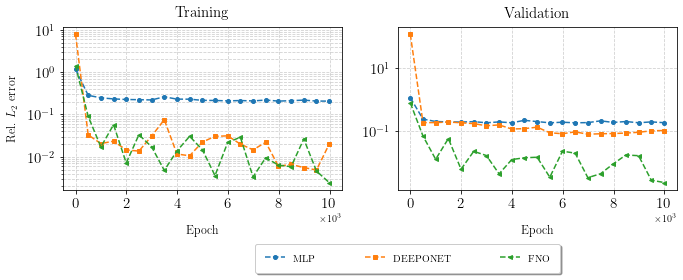

In [29]:
fig, axs = plt.subplots(1, 2, figsize = (11, 3))

for mark, method in zip(['--o', '--s', '--<'], ['MLP', 'DEEPONET', 'FNO']):
    
    l2_err_train = all_methods[method]._method._l2_losses['train']
    l2_err_val = all_methods[method]._method._l2_losses['val']
    
    num_parameters = all_methods[method]._method.num_parameters()
    print(method, num_parameters)
    
    axs[0].plot(range(0, 10000, 499), l2_err_train[::499], mark, markersize=4, label = method)
    axs[1].plot(range(0, 10000, 499), l2_err_val[::499], mark, markersize=4, label = method)

axs[0].set_ylabel('Rel. $L_2$ error', size=12, labelpad = 10)
axs[0].set_title('Training', size = 15, pad = 10)
axs[1].set_title('Validation', size = 15, pad = 10)

for i in range(2):
    
    axs[i].grid(True, which='both', alpha = .6, ls='dashed')
    axs[i].set_yscale('log')
    axs[i].set_xlabel('Epoch', fontsize = 12, labelpad=15)
    
    axs[i].tick_params(axis='both', which='major', labelsize=15)
    # axs[i].set_xlim(-500, 10500)
    axs[i].ticklabel_format(style='sci', axis='x', scilimits=(3, 3))

axs[0].legend(bbox_to_anchor=(1.8, -0.3), ncol=3, columnspacing = 5, shadow = True, borderpad = 1)
plt.savefig('l2_step_4.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 7)) 

for i, (ax, method) in enumerate(zip(axs.flatten(), all_methods)):
    all_methods[method].plot(ax)
    ax.title.set_text(method)
    
fig.tight_layout()
plt.show()

In [ ]:
new_D = logn_fct(solver.x, 1, centers=[0.5])[0]
new_F = delta(0.5, x)

solver.change_D(D=new_D)
solver.change_F(F=new_F)
U_FD = solver.solve

fig, (ax_0, ax_1) = plt.subplots(1, 2, figsize= (12, 4))
ax_0.plot(solver.x, U_FD, '--', label=f'FD (True)')

phi = np.concatenate([new_D.reshape(-1, 1), new_F], -1)
for method in all_methods:
    if method == 'FNO':
        phi_fno = torch.Tensor(phi).unsqueeze(0)
        U_pred = all_methods[method].apply_method(phi = phi_fno, D = new_D, y=new_F).flatten()
    else:
        U_pred = all_methods[method].apply_method(phi = phi, D = new_D, y=new_F).flatten()
    ax_0.plot(solver.x, U_pred, label=f'{method}')
    
ax_0.legend()

OOD_D = logn_fct(solver.x, 1, centers=[0.1])[0]
OOD_F = delta(0.1, x)

solver.change_D(D=OOD_D)
solver.change_F(F=OOD_F)
U_OOD_FD = solver.solve

ax_1.plot(solver.x, U_OOD_FD, '--', label=f'FD (True)')

phi_OOD = np.concatenate([OOD_D.reshape(-1, 1), OOD_F], -1)
for method in all_methods:
    if method == 'FNO':
        phi_OOD_fno = torch.Tensor(phi_OOD).unsqueeze(0)
        U_pred = all_methods[method].apply_method(phi = phi_OOD_fno, D = OOD_D, y=OOD_F).flatten()
    else:
        U_pred = all_methods[method].apply_method(phi = phi, D = OOD_D, y=OOD_F).flatten()
    ax_1.plot(solver.x, U_pred, label=f'{method}')


# ax_1.legend()
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

for i, (ax, method) in enumerate(zip(axs.flatten(), all_methods)):
    if method in ['MLP', 'POD', 'FNO', 'DEEPONET']:
        all_methods[method].parity_plot(U=u_train, phi=df_train, D=df_train[:, :, 0:1], Y=df_train[:, :, 1:2], ax=ax, label=f'Train {method}', color='green')
        all_methods[method].parity_plot(U=u_val, phi=df_val, D=df_val[:, :, 0:1], Y=df_val[:, :, 1:2], ax=ax, label=f'Validation {method}', color='blue')
        ax.legend()
        ax.set_yscale('log')
        ax.set_xscale('log')
    
plt.tight_layout()
plt.show()